In [297]:
import pandas as pd
import networkx as nx
from networkx.algorithms.community import girvan_newman
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [298]:
df = pd.read_csv('data/shopping_trends.csv', nrows=100)
df.head(100)

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,37,Male,Sneakers,Footwear,100,Missouri,L,Pink,Fall,3.8,Yes,PayPal,Free Shipping,Yes,Yes,48,PayPal,Monthly
96,97,32,Male,Gloves,Accessories,73,Delaware,S,Gold,Spring,3.6,Yes,Venmo,Express,Yes,Yes,43,Venmo,Every 3 Months
97,98,21,Male,Shoes,Footwear,92,Virginia,M,Teal,Winter,4.8,Yes,PayPal,Store Pickup,Yes,Yes,37,Cash,Annually
98,99,20,Male,Jeans,Clothing,67,New York,XL,Teal,Spring,2.6,Yes,Cash,Next Day Air,Yes,Yes,20,Bank Transfer,Annually


In [299]:
df[['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']].describe()

,Age,Purchase Amount (USD),Review Rating,Previous Purchases
count,100.000000,100.000000,100.000000,100.00000
mean,43.260000,57.950000,3.871000,28.93000
std,15.508629,23.863405,0.743089,14.10298
min,18.000000,20.000000,2.600000,2.00000
25%,30.750000,37.000000,3.200000,17.00000
50%,45.000000,54.000000,4.050000,31.50000
75%,55.250000,79.000000,4.600000,42.25000
max,70.000000,100.000000,5.000000,50.00000


In [300]:
# Loại bỏ dữ liệu trùng lặp
df = df.drop_duplicates()

# Đếm số lượng dữ liệu khuyết cho từng cột
missing_data_counts = df[['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases',
                          'Item Purchased', 'Category', 'Frequency of Purchases', 'Payment Method']].isna().sum()

print("Số lượng dữ liệu bị khuyết cho từng cột:")
print(missing_data_counts)

# # ===========>>> START Xử Lý Dữ Liệu Thiếu
# # Điền giá trị mode cho các cột số
# df['Age'].fillna(df['Age'].mode()[0], inplace=True)
# df['Purchase Amount (USD)'].fillna(df['Purchase Amount (USD)'].mode()[0], inplace=True)
# df['Review Rating'].fillna(df['Review Rating'].mode()[0], inplace=True)
# df['Previous Purchases'].fillna(df['Previous Purchases'].mode()[0], inplace=True)
# 
# # Điền giá trị mode cho các cột phi số (nếu có dữ liệu thiếu)
# df['Item Purchased'].fillna(df['Item Purchased'].mode()[0], inplace=True)
# df['Category'].fillna(df['Category'].mode()[0], inplace=True)
# df['Frequency of Purchases'].fillna(df['Frequency of Purchases'].mode()[0], inplace=True)
# df['Payment Method'].fillna(df['Payment Method'].mode()[0], inplace=True)
# # ===========>>> END Xử Lý Dữ Liệu Thiếu

# # Sửa lỗi trong cột 'Purchase Amount (USD)'
# df.loc[df['Purchase Amount (USD)'] < 0, 'Purchase Amount (USD)'] = 0

# # Chọn các cột quan trọng
# df_selected_features = df[['Customer ID', 'Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 'Item Purchased', 'Category', 'Frequency of Purchases', 'Payment Method']]
# 
# print("DataFrame với các đặc trưng được chọn lọc:")
# print(df_selected_features.head(1))

Số lượng dữ liệu bị khuyết cho từng cột:
Age                       0
Purchase Amount (USD)     0
Review Rating             0
Previous Purchases        0
Item Purchased            0
Category                  0
Frequency of Purchases    0
Payment Method            0
dtype: int64


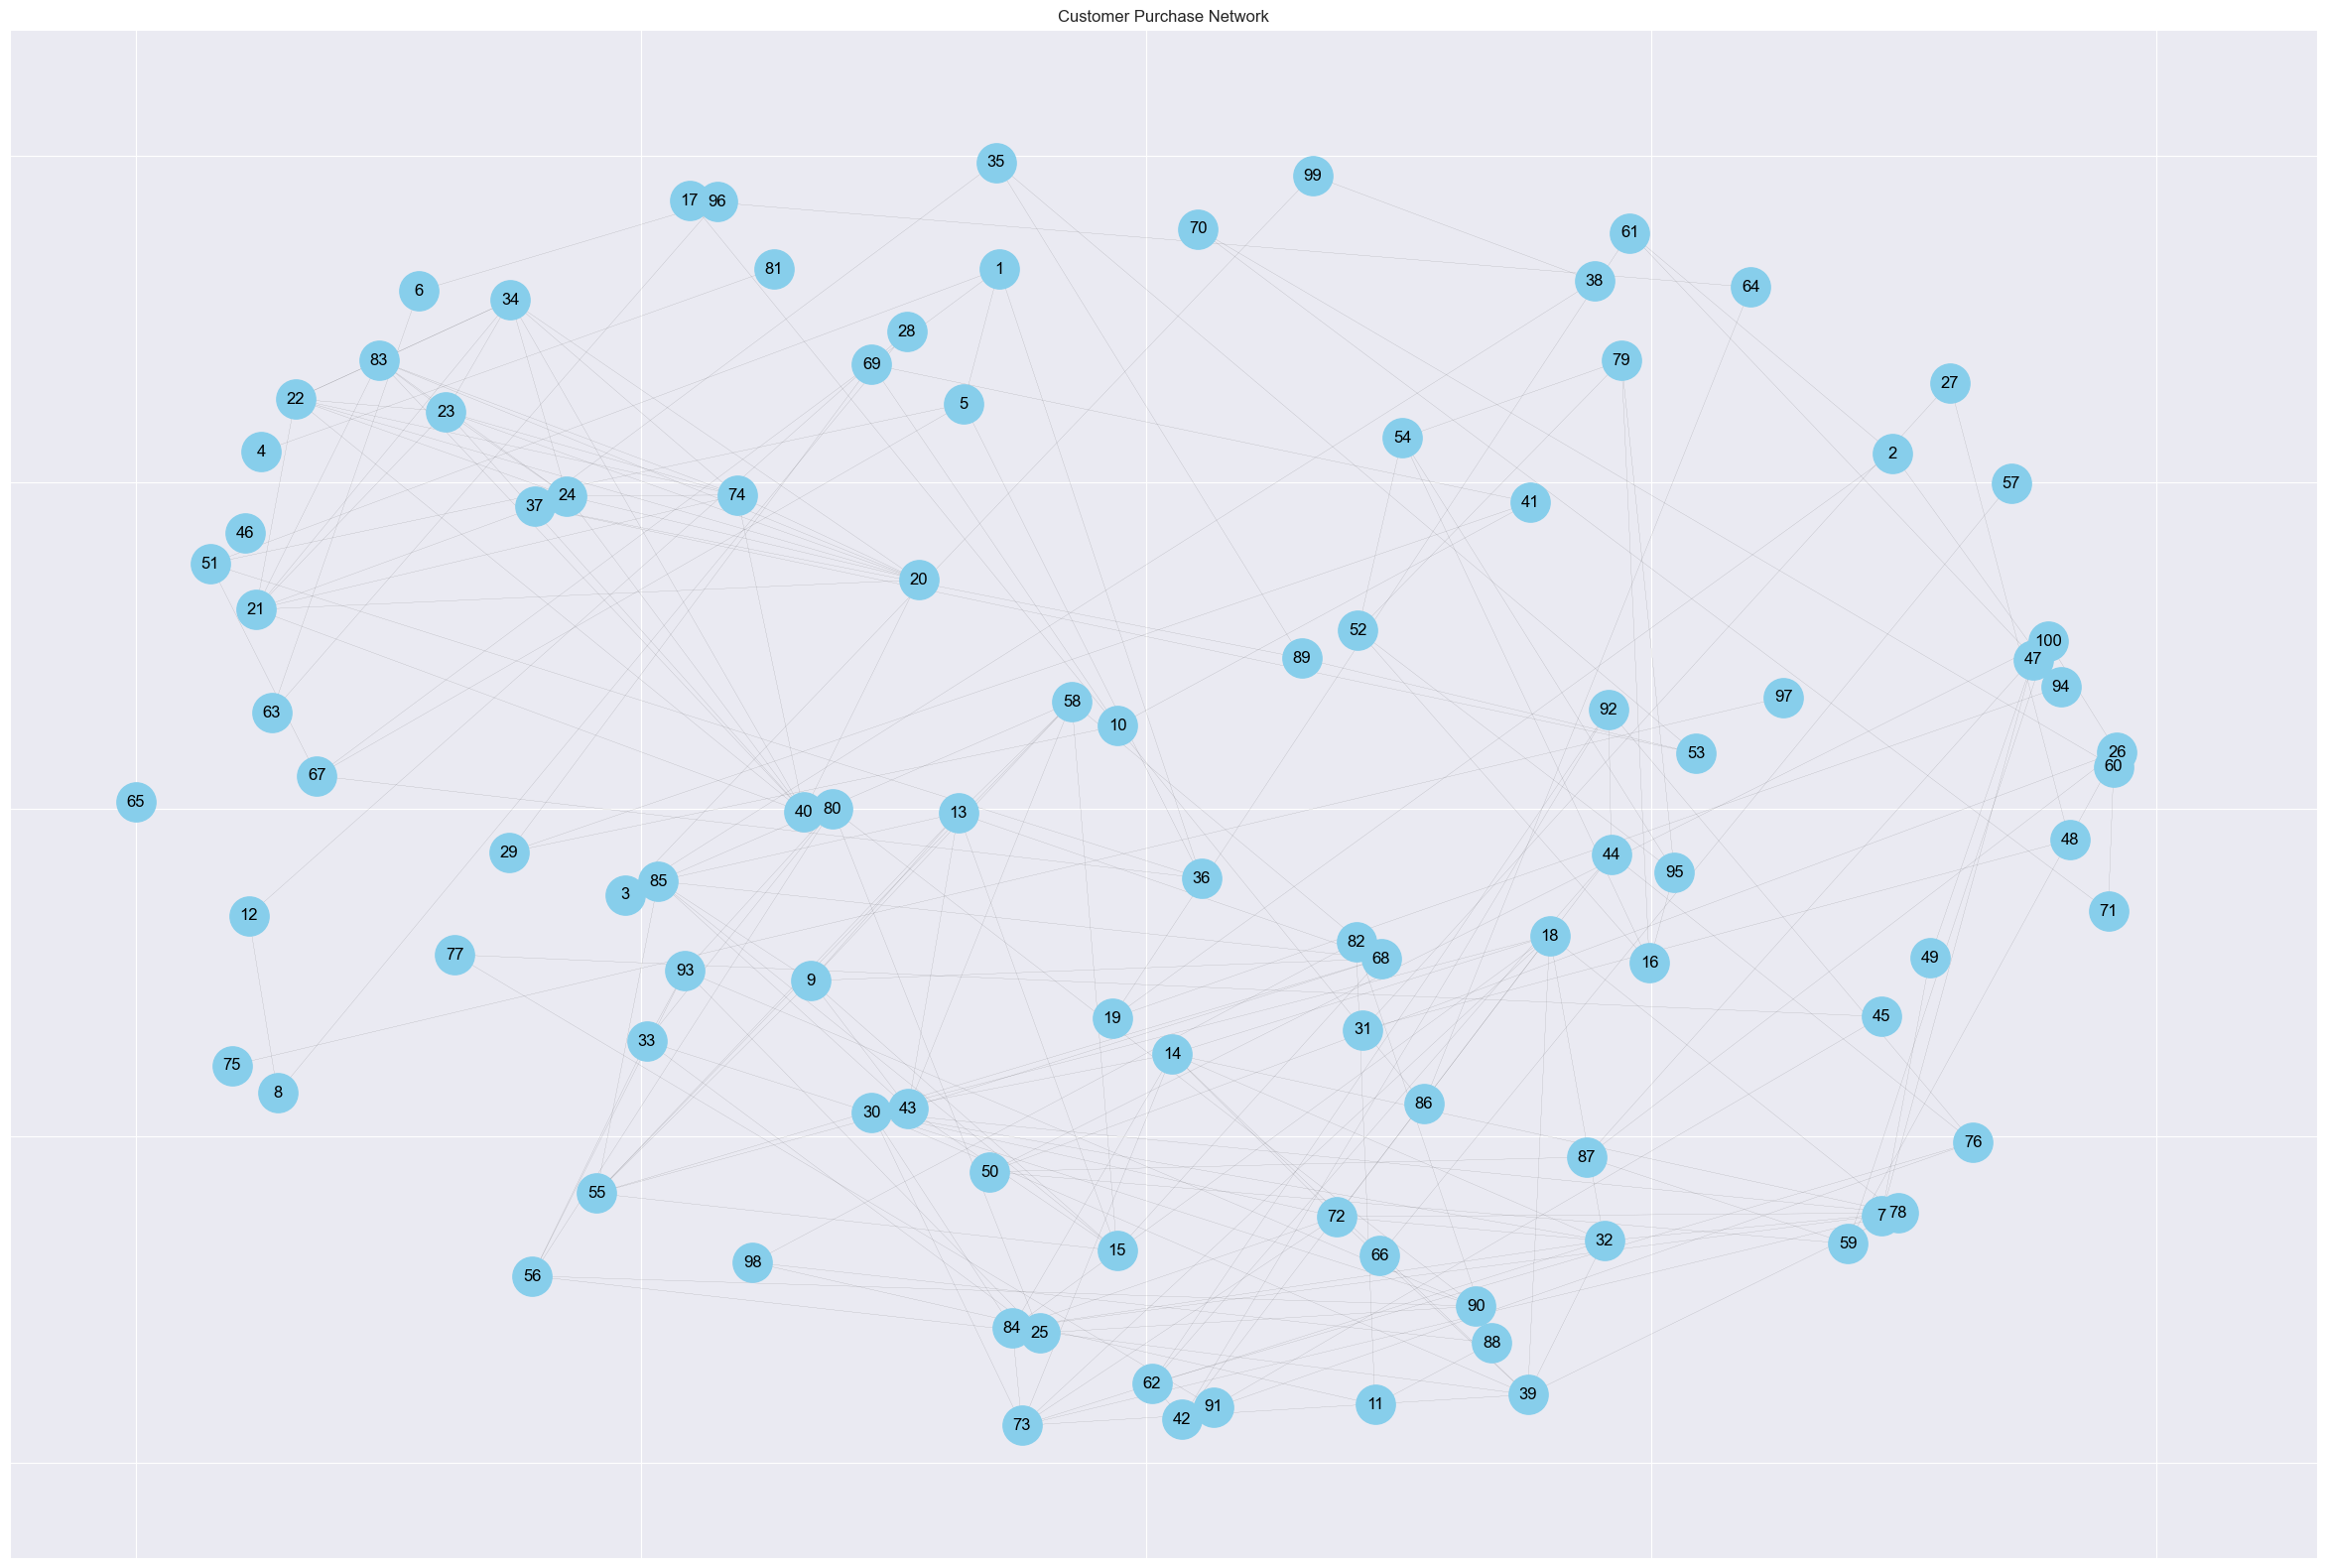

In [301]:
# Khởi tạo đồ thị
G = nx.Graph()

# Thêm các nút vào đồ thị với thuộc tính từ DataFrame
for index, row in df.iterrows():
    G.add_node(row['Customer ID'], **row.to_dict())

# Nhóm dữ liệu theo Category và Item Purchased, tạo danh sách khách hàng cho mỗi nhóm
product_category_groups = df.groupby(['Category', 'Item Purchased'])['Customer ID'].apply(list)

# Tính toán trọng số cho các cạnh
for (category, item), customers in product_category_groups.items():
    if len(customers) > 1:
        for i in range(len(customers)):
            for j in range(i + 1, len(customers)):
                if G.has_edge(customers[i], customers[j]):
                    G[customers[i]][customers[j]]['weight'] += 1
                else:
                    G.add_edge(customers[i], customers[j], weight=1, relationship='purchased_same_item', category=category, item=item)

# Vẽ đồ thị với trọng số cạnh
plt.figure(figsize=(30, 20))  # Kích thước của đồ thị
pos = nx.spring_layout(G, k=1, seed=42)  # Vị trí các nút
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue')
edges = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos, edgelist=edges.keys(), width=[weight * 0.1 for weight in edges.values()], alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Hiển thị đồ thị
plt.title("Customer Purchase Network")
plt.show()


# # Kiểm tra các cạnh đã thêm
# print("Edges in the graph:")
# for edge in G.edges(data=True):
# print(edge)

In [302]:
# Khởi tạo đồ thị
G = nx.Graph()

# Thêm các nút vào đồ thị với thuộc tính từ DataFrame
for index, row in df.iterrows():
    G.add_node(row['Customer ID'], **row.to_dict())

In [303]:
# Nhóm dữ liệu theo Category và Item Purchased, tạo danh sách khách hàng cho mỗi nhóm
product_category_groups = df.groupby(['Category', 'Item Purchased'])['Customer ID'].apply(list)

# Tính toán trọng số cho các cạnh dựa trên 7 yếu tố
def compute_edge_weight(row1, row2):
    weight = 0
    
    # Đánh trọng số dựa trên Age (tỷ lệ chênh lệch tuổi)
    weight += 1 / (abs(row1['Age'] - row2['Age']) + 1)
    
    # Đánh trọng số dựa trên Purchase Amount (USD) (tỷ lệ chênh lệch số tiền mua)
    weight += 1 / (abs(row1['Purchase Amount (USD)'] - row2['Purchase Amount (USD)']) + 1)
    
    # Đánh trọng số dựa trên Review Rating (tỷ lệ chênh lệch đánh giá)
    weight += 1 / (abs(row1['Review Rating'] - row2['Review Rating']) + 1)
    
    # Đánh trọng số dựa trên Previous Purchases (tỷ lệ chênh lệch số lần mua trước đó)
    weight += 1 / (abs(row1['Previous Purchases'] - row2['Previous Purchases']) + 1)
    
    # Đánh trọng số dựa trên Item Purchased (cùng sản phẩm) và Category (cùng danh mục)
    if row1['Item Purchased'] == row2['Item Purchased'] and row1['Category'] == row2['Category']:
        weight += 5  # Cộng thêm trọng số lớn cho việc cùng mua sản phẩm và danh mục
    
    # Đánh trọng số dựa trên Frequency of Purchases (tần suất mua hàng)
    if row1['Frequency of Purchases'] == row2['Frequency of Purchases']:
        weight += 2  # Cộng thêm trọng số cho việc cùng tần suất mua hàng
    
    return weight

# Tính toán trọng số cho các cạnh
for (category, item), customers in product_category_groups.items():
    if len(customers) > 1:
        for i in range(len(customers)):
            for j in range(i + 1, len(customers)):
                c1 = customers[i]
                c2 = customers[j]
                row1 = df[df['Customer ID'] == c1].iloc[0]
                row2 = df[df['Customer ID'] == c2].iloc[0]
                weight = compute_edge_weight(row1, row2)
                
                if G.has_edge(c1, c2):
                    G[c1][c2]['weight'] += weight
                else:
                    G.add_edge(c1, c2, weight=weight, relationship='purchased_same_item', category=category, item=item)


In [304]:
# # Nhóm dữ liệu theo Category và Item Purchased, tạo danh sách khách hàng cho mỗi nhóm
# product_category_groups = df.groupby(['Category', 'Item Purchased'])['Customer ID'].apply(list)
# 
# # Tính toán trọng số cho các cạnh
# for (category, item), customers in product_category_groups.items():
#     if len(customers) > 1:
#         for i in range(len(customers)):
#             for j in range(i + 1, len(customers)):
#                 if G.has_edge(customers[i], customers[j]):
#                     G[customers[i]][customers[j]]['weight'] += 1
#                 else:
#                     G.add_edge(customers[i], customers[j], weight=1, relationship='purchased_same_item', category=category, item=item)

In [305]:
# # Hiển thị các nút và cạnh của đồ thị
# print("\nCác nút trong đồ thị:")
# print(G.nodes(data=True))
# 
# print("\nCác cạnh trong đồ thị:")
# print(G.edges(data=True))


Các nút trong đồ thị:
[(1, {'Customer ID': 1, 'Age': 55, 'Gender': 'Male', 'Item Purchased': 'Blouse', 'Category': 'Clothing', 'Purchase Amount (USD)': 53, 'Location': 'Kentucky', 'Size': 'L', 'Color': 'Gray', 'Season': 'Winter', 'Review Rating': 3.1, 'Subscription Status': 'Yes', 'Payment Method': 'Credit Card', 'Shipping Type': 'Express', 'Discount Applied': 'Yes', 'Promo Code Used': 'Yes', 'Previous Purchases': 14, 'Preferred Payment Method': 'Venmo', 'Frequency of Purchases': 'Fortnightly'}), (2, {'Customer ID': 2, 'Age': 19, 'Gender': 'Male', 'Item Purchased': 'Sweater', 'Category': 'Clothing', 'Purchase Amount (USD)': 64, 'Location': 'Maine', 'Size': 'L', 'Color': 'Maroon', 'Season': 'Winter', 'Review Rating': 3.1, 'Subscription Status': 'Yes', 'Payment Method': 'Bank Transfer', 'Shipping Type': 'Express', 'Discount Applied': 'Yes', 'Promo Code Used': 'Yes', 'Previous Purchases': 2, 'Preferred Payment Method': 'Cash', 'Frequency of Purchases': 'Fortnightly'}), (3, {'Customer ID'

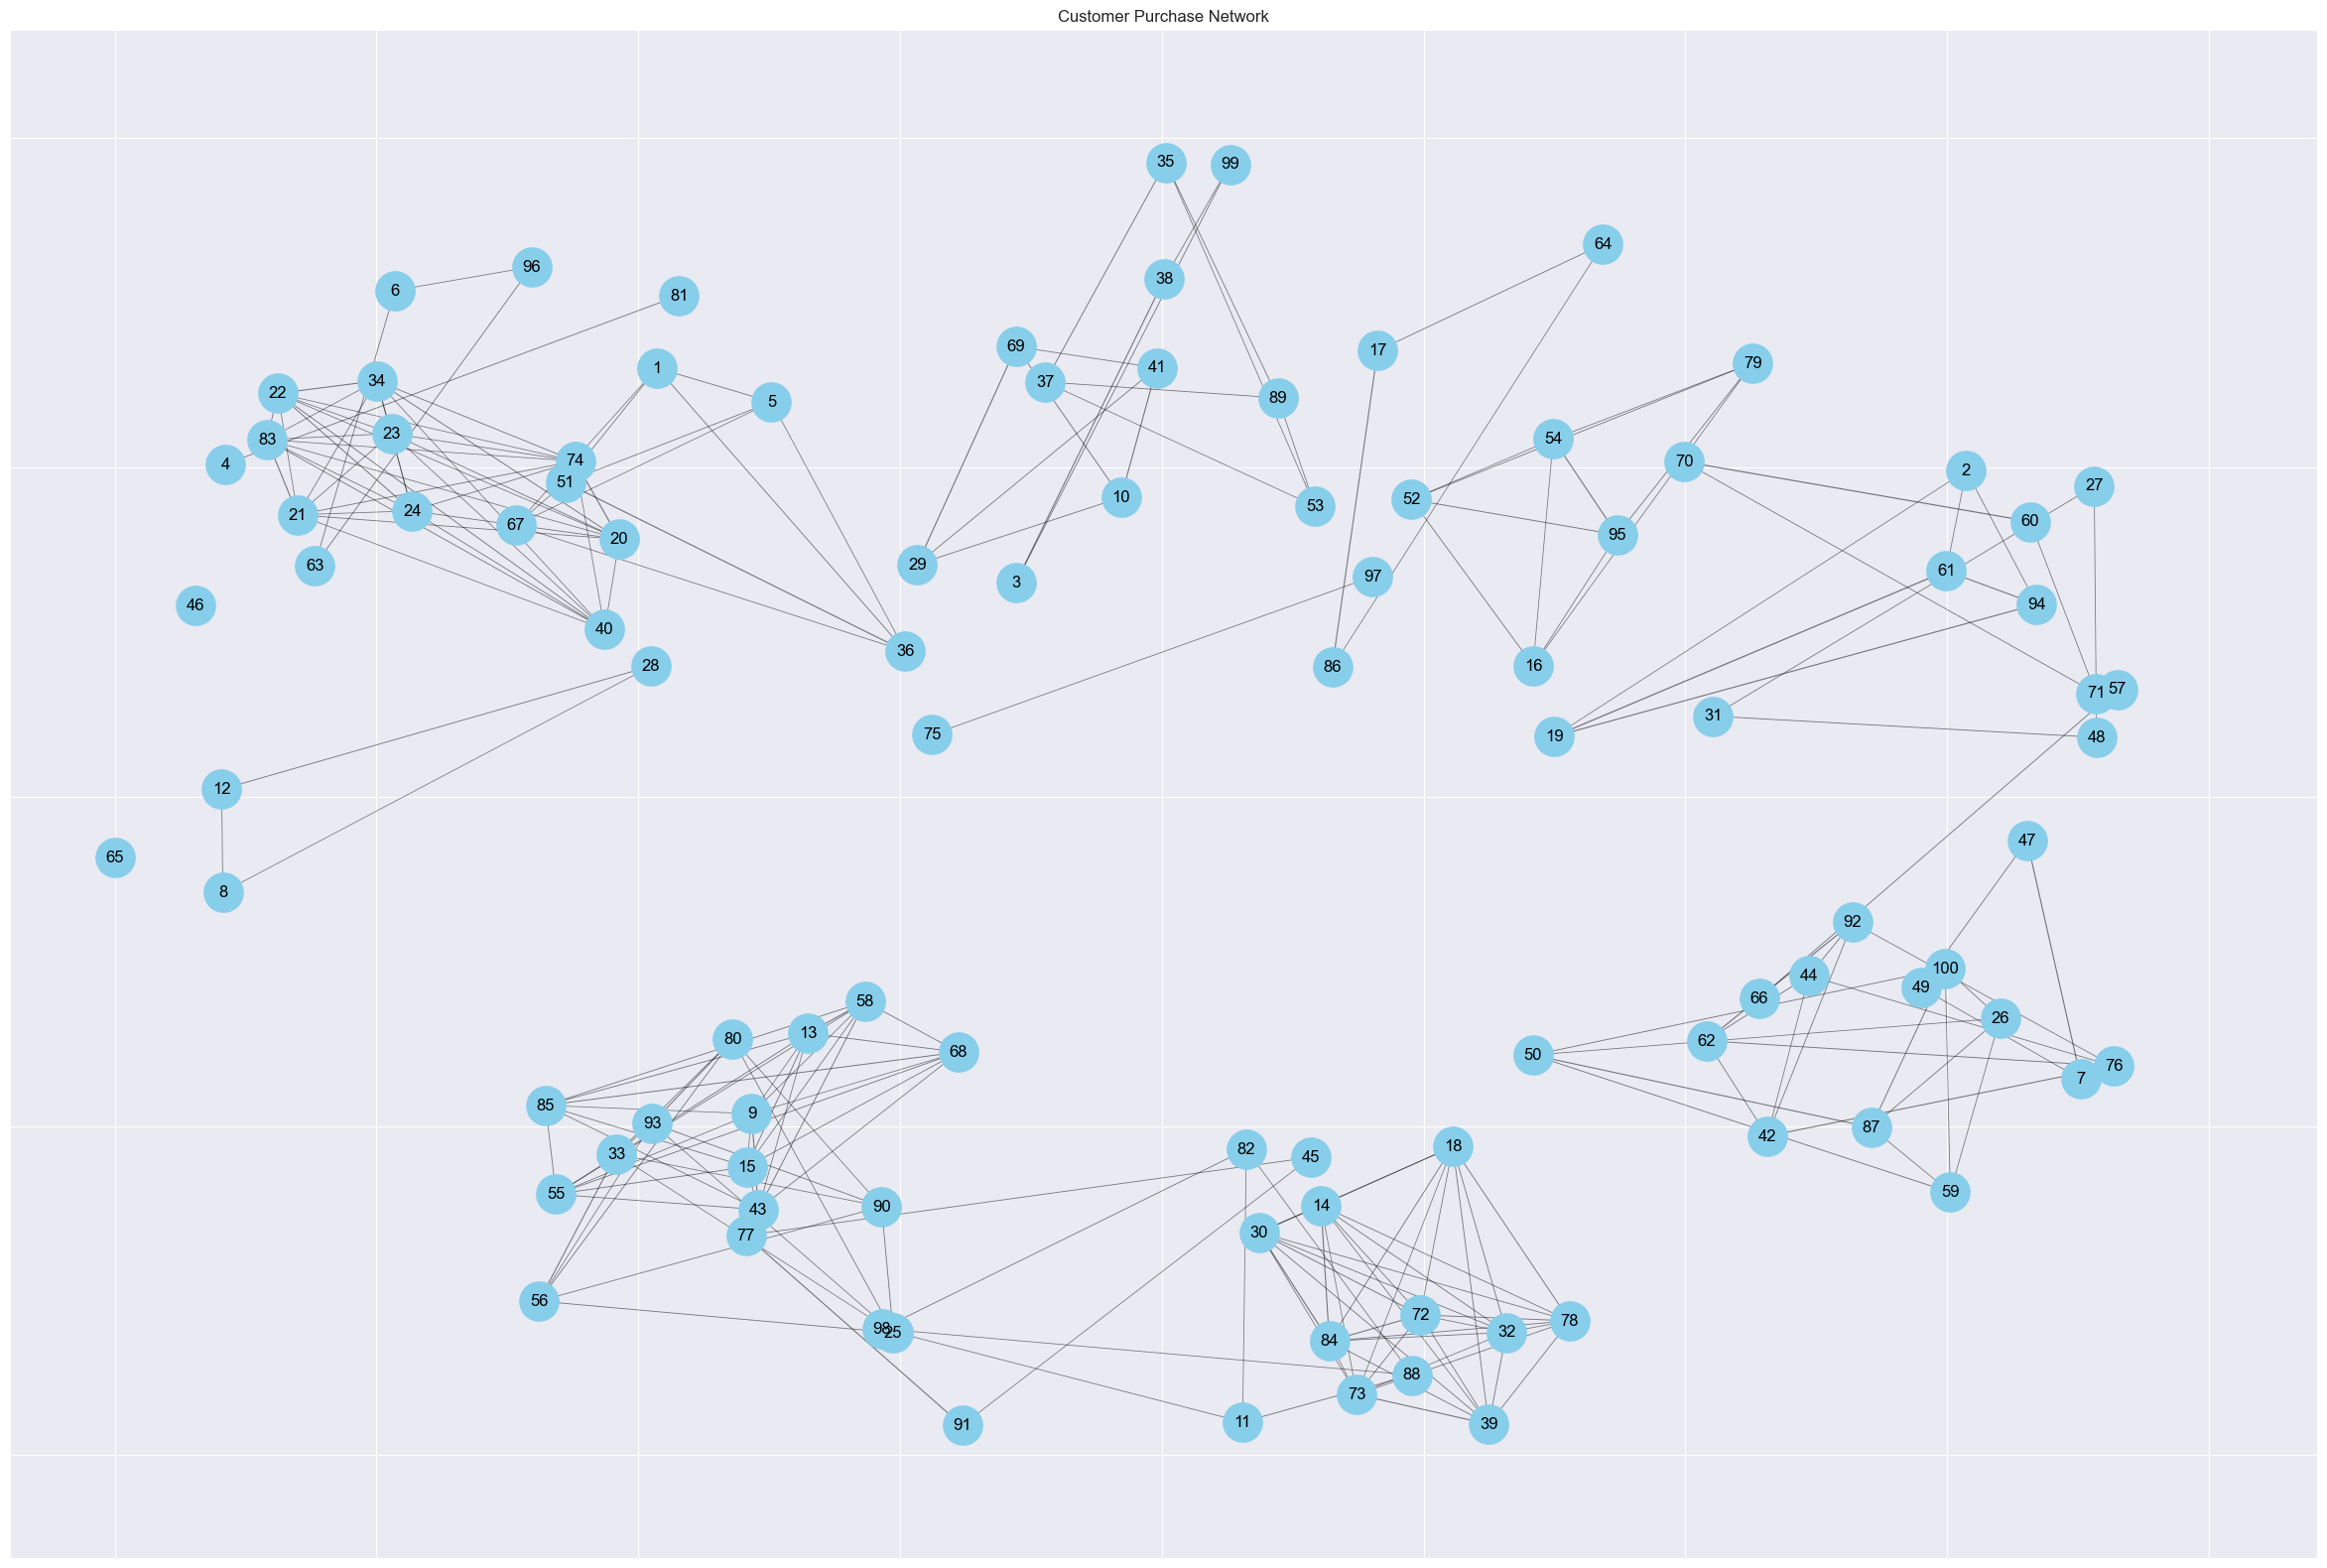

In [306]:
# Vẽ đồ thị với trọng số cạnh
plt.figure(figsize=(30, 20))  # Kích thước của đồ thị
pos = nx.spring_layout(G, k=1, seed=42)  # Vị trí các nút
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue')
edges = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos, edgelist=edges.keys(), width=[weight * 0.1 for weight in edges.values()], alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Hiển thị đồ thị
plt.title("Customer Purchase Network")
plt.show()


# # Kiểm tra các cạnh đã thêm
# print("Edges in the graph:")
# for edge in G.edges(data=True):
# print(edge)

In [307]:
def girvan_newman(G):
    # Danh sách để lưu các cộng đồng
    communities = []
    
    # Lặp cho đến khi đồ thị còn nhiều hơn 1 thành phần liên thông
    while nx.number_connected_components(G) == 1:
        # Tính toán betweenness centrality cho các cạnh
        edge_betweenness = nx.edge_betweenness_centrality(G)
        
        # Tìm các cạnh có betweenness centrality cao nhất
        edge_to_remove = max(edge_betweenness, key=edge_betweenness.get)
        
        # Loại bỏ các cạnh có betweenness centrality cao nhất
        G.remove_edge(*edge_to_remove)
    
    # Lưu các cộng đồng
    for component in nx.connected_components(G):
        communities.append(component)
    
    return communities

# Áp dụng giải thuật Girvan-Newman
communities = girvan_newman(G)

# In kết quả
print("Communities found:", communities)

Communities found: [{1, 67, 36, 5, 51}, {2, 19, 61, 94}, {99, 3, 38}, {81, 4}, {96, 6, 63}, {49, 47, 7}, {8, 12, 28}, {68, 9, 43, 13, 15, 85, 55, 58}, {41, 10, 69, 29}, {88, 82, 11, 98}, {32, 39, 72, 73, 14, 78, 18, 84, 30}, {79, 16, 52, 54, 95}, {64, 17, 86}, {34, 40, 74, 83, 20, 21, 22, 23, 24}, {33, 80, 56, 25, 90, 93}, {100, 50, 87, 26, 59}, {48, 27, 31}, {53, 89, 35, 37}, {42, 44, 76, 92, 62}, {91, 77, 45}, {46}, {57, 66}, {60, 70, 71}, {65}, {97, 75}]


In [308]:
# # Áp dụng giải thuật Girvan-Newman
# communities = girvan_newman(G)
# 
# # Lấy kết quả phân hoạch của các cộng đồng
# first_level_communities = next(communities)
# print(list(first_level_communities))

{1, 67, 36, 5, 51}
{2, 19, 61, 94}
{99, 3, 38}
{81, 4}
{96, 6, 63}
{49, 47, 7}
{8, 12, 28}
{68, 9, 43, 13, 15, 85, 55, 58}
{41, 10, 69, 29}
{88, 82, 11, 98}
{32, 39, 72, 73, 14, 78, 18, 84, 30}
{79, 16, 52, 54, 95}
{64, 17, 86}
{34, 40, 74, 83, 20, 21, 22, 23, 24}
{33, 80, 56, 25, 90, 93}
{100, 50, 87, 26, 59}
{48, 27, 31}
{53, 89, 35, 37}
{42, 44, 76, 92, 62}
{91, 77, 45}
{46}
{57, 66}
{60, 70, 71}
{65}
{97, 75}


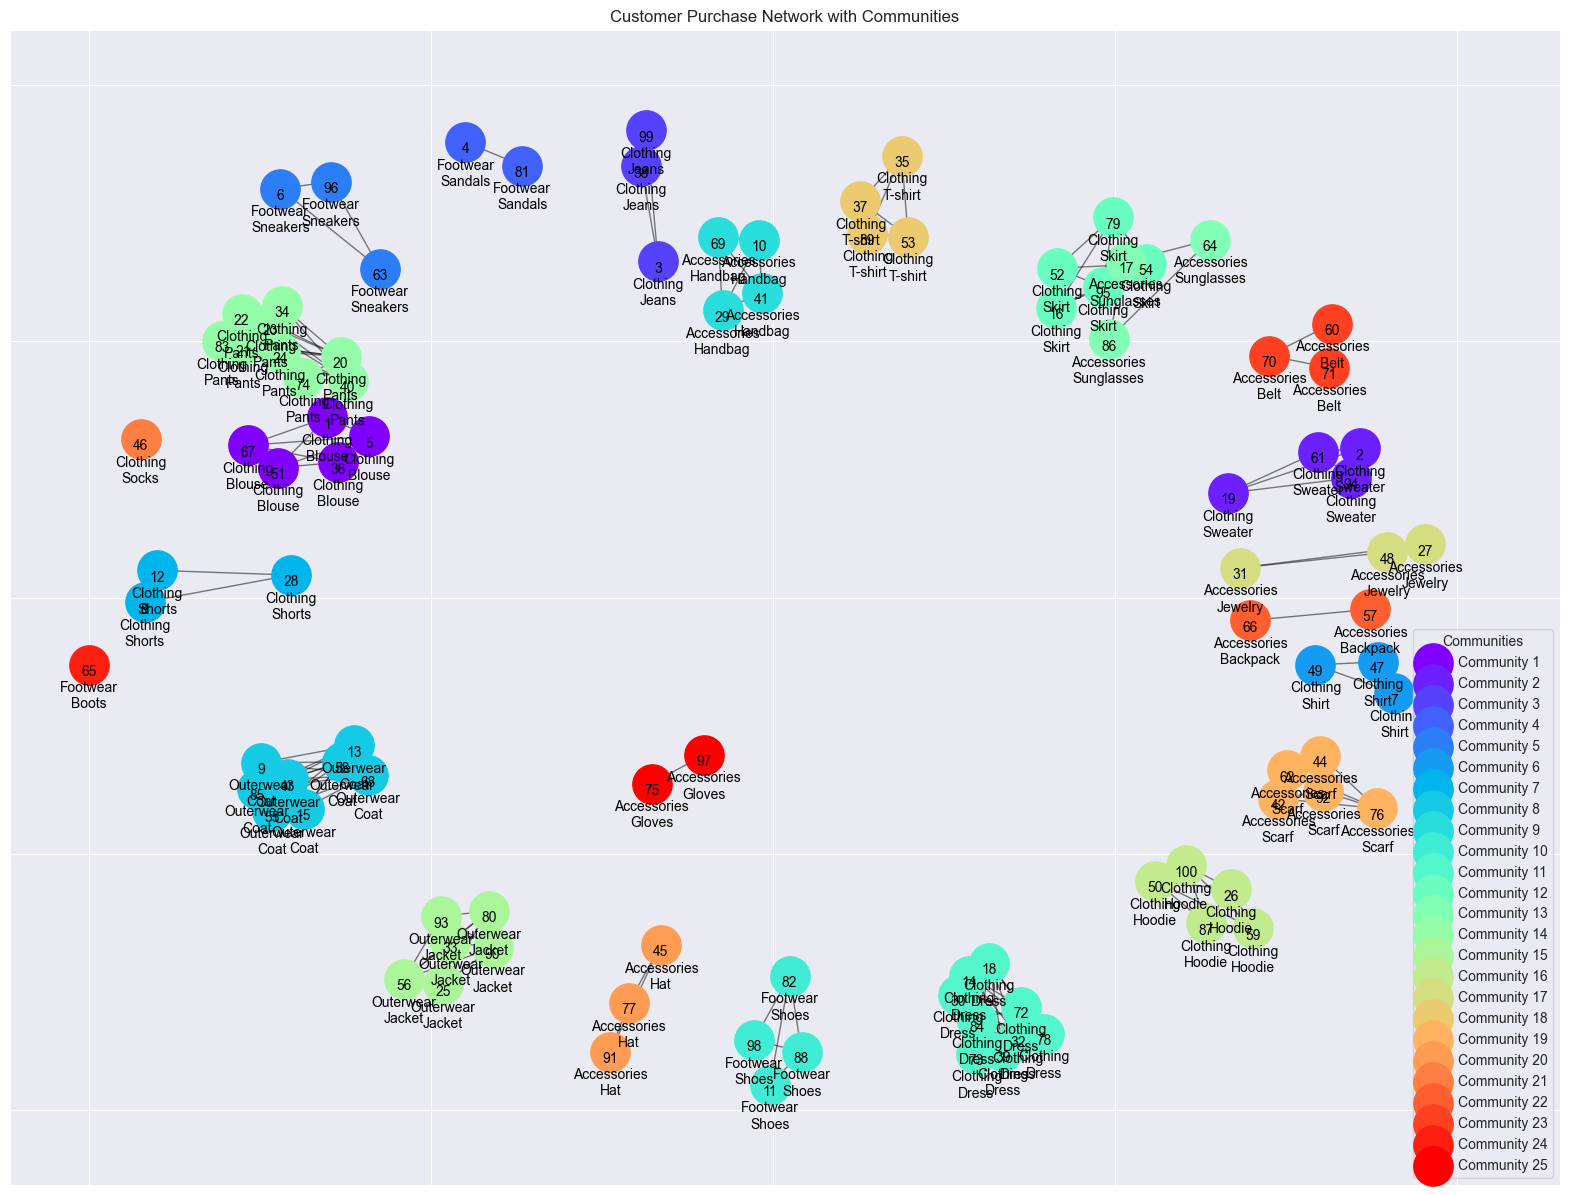

In [309]:

# Giải thuật Girvan-Newman
def girvan_newman(G):
    communities = []
    while nx.number_connected_components(G) == 1:
        edge_betweenness = nx.edge_betweenness_centrality(G)
        edge_to_remove = max(edge_betweenness, key=edge_betweenness.get)
        G.remove_edge(*edge_to_remove)
    for component in nx.connected_components(G):
        print(component)
        communities.append(component)
    return communities

# Áp dụng giải thuật Girvan-Newman
communities = girvan_newman(G)

# Tạo danh sách màu sắc cho các cộng đồng
colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))

# Vẽ đồ thị
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, k=0.5, seed=42)

# Vẽ các nút và cạnh
for i, community in enumerate(communities):
    # print(community)
    # print(communities)
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[colors[i]], node_size=800, label=f'Community {i+1}')

# Vẽ các cạnh
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1.0, alpha=0.5)

# Tạo nhãn cho các nút với thông tin từ thuộc tính
labels = {}
for node in G.nodes(data=True):
    customer_id = node[0]
    attributes = node[1]
    # Tạo nhãn cho mỗi nút bao gồm Customer ID, Category và Item Purchased
    labels[customer_id] = f"{customer_id}\n{attributes.get('Category', 'N/A')}\n{attributes.get('Item Purchased', 'N/A')}"

# Vẽ nhãn cho các nút
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_family='sans-serif', verticalalignment='top')

# Thêm chú giải cho các cộng đồng
plt.legend(loc='best', title="Communities", fontsize=10)
plt.title("Customer Purchase Network with Communities")
plt.show()

In [310]:
# # Vẽ đồ thị với các cộng đồng được phân biệt bằng màu sắc
# pos = nx.spring_layout(G)
# plt.figure(figsize=(12, 12))
# 
# # Vẽ các cộng đồng
# for community in first_level_communities:
#     nodes = list(community)
#     nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='red')
#     nx.draw_networkx_edges(G, pos)
#     nx.draw_networkx_labels(G, pos)
# 
# lt.show()

count     6.000000
mean     44.333333
std      11.961048
min      21.000000
25%      45.250000
50%      47.500000
75%      49.750000
max      55.000000
Name: Age, dtype: float64


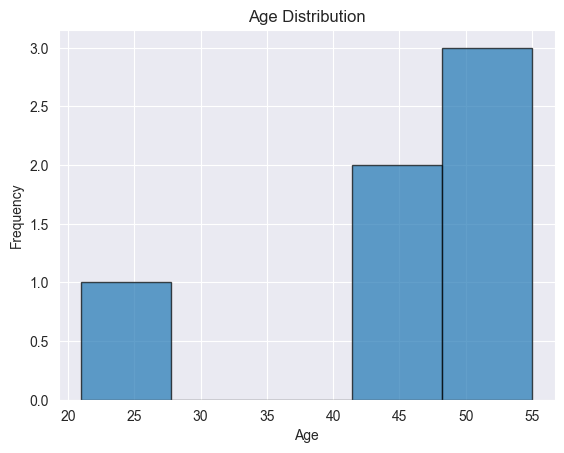

In [311]:
import pandas as pd
import matplotlib.pyplot as plt

# Dữ liệu ví dụ
data = {'Age': [55, 49, 50, 21, 45, 46]}
df = pd.DataFrame(data)

# Thống kê mô tả
print(df['Age'].describe())

# Trực quan hóa
plt.hist(df['Age'], bins=5, edgecolor='k', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


                            Age  Purchase Amount (USD)
Age                    1.000000              -0.508067
Purchase Amount (USD) -0.508067               1.000000


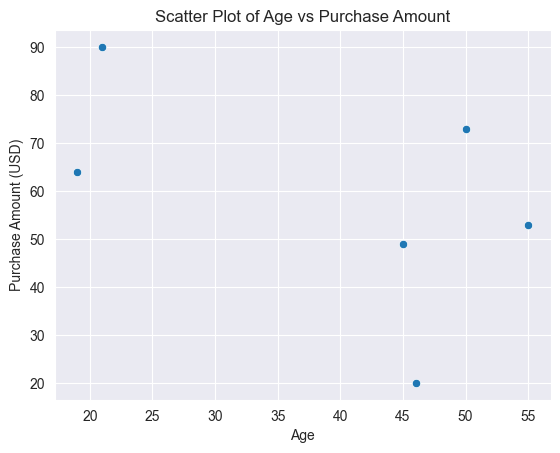

In [312]:
import seaborn as sns

# Dữ liệu ví dụ
data = {'Age': [55, 19, 50, 21, 45, 46],
        'Purchase Amount (USD)': [53, 64, 73, 90, 49, 20]}
df = pd.DataFrame(data)

# Tương quan
correlation = df.corr()
print(correlation)

# Trực quan hóa
sns.scatterplot(x='Age', y='Purchase Amount (USD)', data=df)
plt.title('Scatter Plot of Age vs Purchase Amount')
plt.xlabel('Age')
plt.ylabel('Purchase Amount (USD)')
plt.show()
